# Feature Selection for D-Features

## import libraries

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFECV

## load data

In [73]:
dataframe = pd.read_csv('data/all_D_features.csv')
dataframe.head()

,Unnamed: 0,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,isFraud
0,0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,0
1,1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0
2,2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,0
3,3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,0
4,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## remove useless column (row ID?)

In [74]:
dataframe = dataframe.drop('Unnamed: 0', axis=1)
dataframe.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,isFraud
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## check percentage NaNs in each column

In [75]:
for column in dataframe.columns:
    num_nans = dataframe[column].isna().sum()
    print('percentage of NaNs for {}: {:.3f}'.format(
        column, 
        num_nans / len(dataframe) * 100
    ))

percentage of NaNs for D1: 0.215
percentage of NaNs for D2: 47.549
percentage of NaNs for D3: 44.515
percentage of NaNs for D4: 28.605
percentage of NaNs for D5: 52.467
percentage of NaNs for D6: 87.607
percentage of NaNs for D7: 93.410
percentage of NaNs for D8: 87.312
percentage of NaNs for D9: 87.312
percentage of NaNs for D10: 12.873
percentage of NaNs for D11: 47.293
percentage of NaNs for D12: 89.041
percentage of NaNs for D13: 89.509
percentage of NaNs for D14: 89.469
percentage of NaNs for D15: 15.090
percentage of NaNs for isFraud: 0.000


## remove columns with a lot of NaNs

In [76]:
# keep columns with less than 60% NaNs
less_nan_dataframe = dataframe.loc[:, dataframe.isna().mean() < 0.6]
less_nan_dataframe.head()

,D1,D2,D3,D4,D5,D10,D11,D15,isFraud
0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,0
1,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0
2,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,0
3,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## check for correlated features

In [83]:
correlation_threshold = 0.9

correlated_features = set()
correlation_matrix = less_nan_dataframe.drop('isFraud', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        print('{} is correlated to {} by a factor of {:.3f}'.format(
            correlation_matrix.columns[i],
            correlation_matrix.columns[j],
            abs(correlation_matrix.iloc[i, j])
        ))
        
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(correlated_features)

D2 is correlated to D1 by a factor of 0.981
D3 is correlated to D1 by a factor of 0.280
D3 is correlated to D2 by a factor of 0.266
D4 is correlated to D1 by a factor of 0.586
D4 is correlated to D2 by a factor of 0.570
D4 is correlated to D3 by a factor of 0.149
D5 is correlated to D1 by a factor of 0.055
D5 is correlated to D2 by a factor of 0.238
D5 is correlated to D3 by a factor of 0.707
D5 is correlated to D4 by a factor of 0.314
D10 is correlated to D1 by a factor of 0.562
D10 is correlated to D2 by a factor of 0.526
D10 is correlated to D3 by a factor of 0.092
D10 is correlated to D4 by a factor of 0.637
D10 is correlated to D5 by a factor of 0.117
D11 is correlated to D1 by a factor of 0.593
D11 is correlated to D2 by a factor of 0.563
D11 is correlated to D3 by a factor of 0.055
D11 is correlated to D4 by a factor of 0.658
D11 is correlated to D5 by a factor of 0.058
D11 is correlated to D10 by a factor of 0.610
D15 is correlated to D1 by a factor of 0.639
D15 is correlated t

## drop correlated features (>0.90)

In [84]:
less_nan_dataframe = less_nan_dataframe.drop(correlated_features, axis=1)
less_nan_dataframe.head()

,D1,D3,D4,D5,D10,D11,D15,isFraud
0,14.0,13.0,NaN,NaN,13.0,13.0,0.0,0
1,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0
2,0.0,NaN,0.0,NaN,0.0,315.0,315.0,0
3,112.0,0.0,94.0,0.0,84.0,NaN,111.0,0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0


## imputation

In [85]:
# replace NaN with interquartile mean
less_nan_dataframe = less_nan_dataframe.fillna(dataframe.quantile().mean())
less_nan_dataframe.head()

,D1,D3,D4,D5,D10,D11,D15,isFraud
0,14.0,13.000000,18.283854,18.283854,13.000000,13.000000,0.000000,0
1,0.0,18.283854,0.000000,18.283854,0.000000,18.283854,0.000000,0
2,0.0,18.283854,0.000000,18.283854,0.000000,315.000000,315.000000,0
3,112.0,0.000000,94.000000,0.000000,84.000000,18.283854,111.000000,0
4,0.0,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,0


## do RFE with CV using SVM and SGD

In [86]:
%%time

no_fraud_column_dataframe = less_nan_dataframe.drop('isFraud', axis=1)
is_fraud_data = less_nan_dataframe['isFraud']

sgd_classifier = SGDClassifier(early_stopping=True, n_jobs=2, verbose=1)
rfecv = RFECV(sgd_classifier, scoring='accuracy', n_jobs=2, verbose=1)

rfecv.fit(no_fraud_column_dataframe, is_fraud_data)

Fitting estimator with 7 features.
-- Epoch 1
Norm: 17.37, NNZs: 7, Bias: 8.613788, T: 531486, Avg. loss: 320.895225
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 5.26, NNZs: 7, Bias: 0.503097, T: 1062972, Avg. loss: 34.948917
Total training time: 0.21 seconds.
-- Epoch 3
Norm: 3.92, NNZs: 7, Bias: -0.602872, T: 1594458, Avg. loss: 20.784233
Total training time: 0.36 seconds.
-- Epoch 4
Norm: 1.81, NNZs: 7, Bias: 0.347284, T: 2125944, Avg. loss: 14.833100
Total training time: 0.49 seconds.
-- Epoch 5
Norm: 3.87, NNZs: 7, Bias: 0.129754, T: 2657430, Avg. loss: 11.544148
Total training time: 0.63 seconds.
-- Epoch 6
Norm: 3.57, NNZs: 7, Bias: -0.258980, T: 3188916, Avg. loss: 9.418009
Total training time: 0.76 seconds.
Convergence after 6 epochs took 0.83 seconds
Fitting estimator with 6 features.
-- Epoch 1
Norm: 12.08, NNZs: 6, Bias: -0.753536, T: 531486, Avg. loss: 321.952448
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 5.28, NNZs: 6, Bias: -0.889443, T: 1062972, Avg. los

RFECV(cv=None,
      estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                              early_stopping=True, epsilon=0.1, eta0=0.0,
                              fit_intercept=True, l1_ratio=0.15,
                              learning_rate='optimal', loss='hinge',
                              max_iter=1000, n_iter_no_change=5, n_jobs=2,
                              penalty='l2', power_t=0.5, random_state=None,
                              shuffle=True, tol=0.001, validation_fraction=0.1,
                              verbose=1, warm_start=False),
      min_features_to_select=1, n_jobs=2, scoring='accuracy', step=1,
      verbose=1)

In [87]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 1


## plot of accuracy vs number of features

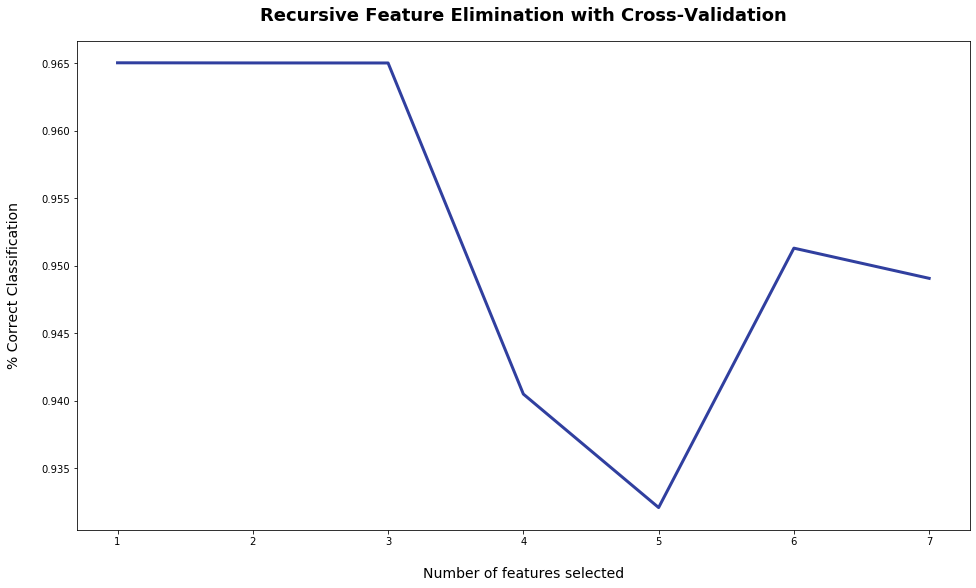

In [88]:
plt.figure(figsize=(16, 9))
plt.title(
    'Recursive Feature Elimination with Cross-Validation', 
    fontsize=18, fontweight='bold', pad=20
)

plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)

plt.plot(
    range(1, len(rfecv.grid_scores_) + 1), 
    rfecv.grid_scores_, color='#303F9F', linewidth=3
)

plt.show()

## show feature ranking

In [92]:
# https://stackoverflow.com/a/50389174/9171260
print(rfecv.ranking_)

[2 7 4 3 6 1 5]


- based on plot and ranking, we should use D11 only?
- maybe D1 and D5 too?

## do RFE with CV using Random Forest

In [93]:
%%time

no_fraud_column_dataframe = less_nan_dataframe.drop('isFraud', axis=1)
is_fraud_data = less_nan_dataframe['isFraud']

rf_classifier = RandomForestClassifier(n_jobs=2, verbose=1)
rfecv = RFECV(rf_classifier, scoring='accuracy', n_jobs=2, verbose=1)

rfecv.fit(no_fraud_column_dataframe, is_fraud_data)

Fitting estimator with 7 features.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   32.2s finished


Fitting estimator with 6 features.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   32.8s finished


Fitting estimator with 5 features.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   29.8s finished


Fitting estimator with 4 features.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   28.4s finished


Fitting estimator with 3 features.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   19.6s finished


Fitting estimator with 2 features.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   18.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.3s


CPU times: user 6min 17s, sys: 459 ms, total: 6min 17s
Wall time: 11min 59s


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   13.8s finished


RFECV(cv=None,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=2,
                                       oob_score=False, random_state=None,
                                       verbose=1, warm_start=False),
      min_features_to_select=1, n_jobs=2, scoring='accuracy', step=1,
      verbose=1)

In [94]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 1


## show feature ranking

In [95]:
print(rfecv.ranking_)

[3 7 1 6 4 5 2]


- now we are supposed to use D4??!

## plot of accuracy vs number of features

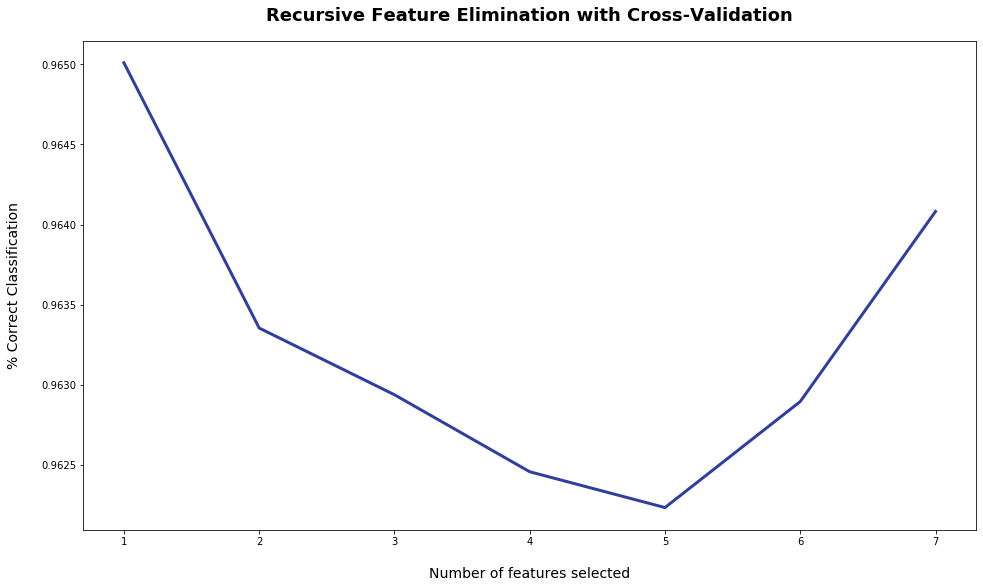

In [96]:
plt.figure(figsize=(16, 9))
plt.title(
    'Recursive Feature Elimination with Cross-Validation', 
    fontsize=18, fontweight='bold', pad=20
)

plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)

plt.plot(
    range(1, len(rfecv.grid_scores_) + 1), 
    rfecv.grid_scores_, color='#303F9F', linewidth=3
)

plt.show()

## imputation

In [99]:
# replace NaN with interquartile mean
dataframe = dataframe.fillna(dataframe.quantile().mean())
dataframe.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,isFraud
0,14.0,18.283854,13.000000,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,13.000000,13.000000,18.283854,18.283854,18.283854,0.000000,0
1,0.0,18.283854,18.283854,0.000000,18.283854,18.283854,18.283854,18.283854,18.283854,0.000000,18.283854,18.283854,18.283854,18.283854,0.000000,0
2,0.0,18.283854,18.283854,0.000000,18.283854,18.283854,18.283854,18.283854,18.283854,0.000000,315.000000,18.283854,18.283854,18.283854,315.000000,0
3,112.0,112.000000,0.000000,94.000000,0.000000,18.283854,18.283854,18.283854,18.283854,84.000000,18.283854,18.283854,18.283854,18.283854,111.000000,0
4,0.0,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,0


## check for feature correlation

In [100]:
correlation_threshold = 0.8

correlated_features = set()
correlation_matrix = dataframe.drop('isFraud', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        print('{} is correlated to {} by a factor of {:.3f}'.format(
            correlation_matrix.columns[i],
            correlation_matrix.columns[j],
            abs(correlation_matrix.iloc[i, j])
        ))
        
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(correlated_features)

D2 is correlated to D1 by a factor of 0.971
D3 is correlated to D1 by a factor of 0.287
D3 is correlated to D2 by a factor of 0.249
D4 is correlated to D1 by a factor of 0.489
D4 is correlated to D2 by a factor of 0.479
D4 is correlated to D3 by a factor of 0.149
D5 is correlated to D1 by a factor of 0.092
D5 is correlated to D2 by a factor of 0.087
D5 is correlated to D3 by a factor of 0.374
D5 is correlated to D4 by a factor of 0.362
D6 is correlated to D1 by a factor of 0.082
D6 is correlated to D2 by a factor of 0.074
D6 is correlated to D3 by a factor of 0.093
D6 is correlated to D4 by a factor of 0.162
D6 is correlated to D5 by a factor of 0.182
D7 is correlated to D1 by a factor of 0.035
D7 is correlated to D2 by a factor of 0.034
D7 is correlated to D3 by a factor of 0.163
D7 is correlated to D4 by a factor of 0.125
D7 is correlated to D5 by a factor of 0.360
D7 is correlated to D6 by a factor of 0.534
D8 is correlated to D1 by a factor of 0.053
D8 is correlated to D2 by a fact

## drop correlated features (>0.80)

In [101]:
dataframe = dataframe.drop(correlated_features, axis=1)
dataframe.head()

,D1,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,isFraud
0,14.0,13.000000,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,13.000000,13.000000,18.283854,18.283854,18.283854,0.000000,0
1,0.0,18.283854,0.000000,18.283854,18.283854,18.283854,18.283854,18.283854,0.000000,18.283854,18.283854,18.283854,18.283854,0.000000,0
2,0.0,18.283854,0.000000,18.283854,18.283854,18.283854,18.283854,18.283854,0.000000,315.000000,18.283854,18.283854,18.283854,315.000000,0
3,112.0,0.000000,94.000000,0.000000,18.283854,18.283854,18.283854,18.283854,84.000000,18.283854,18.283854,18.283854,18.283854,111.000000,0
4,0.0,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,18.283854,0


## do RFE with CV using SVM and SGD

In [102]:
%%time

no_fraud_column_dataframe = dataframe.drop('isFraud', axis=1)
is_fraud_data = dataframe['isFraud']

sgd_classifier = SGDClassifier(early_stopping=True, n_jobs=2, verbose=1)
rfecv = RFECV(sgd_classifier, scoring='accuracy', n_jobs=2, verbose=1)

rfecv.fit(no_fraud_column_dataframe, is_fraud_data)

Fitting estimator with 14 features.
-- Epoch 1
Norm: 17.97, NNZs: 14, Bias: 285.015484, T: 531486, Avg. loss: 421.837170
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 15.90, NNZs: 14, Bias: 228.209554, T: 1062972, Avg. loss: 46.797563
Total training time: 0.23 seconds.
-- Epoch 3
Norm: 8.53, NNZs: 14, Bias: 182.938229, T: 1594458, Avg. loss: 27.734479
Total training time: 0.38 seconds.
-- Epoch 4
Norm: 8.14, NNZs: 14, Bias: 147.006227, T: 2125944, Avg. loss: 19.909757
Total training time: 0.53 seconds.
-- Epoch 5
Norm: 5.01, NNZs: 14, Bias: 118.531700, T: 2657430, Avg. loss: 15.576182
Total training time: 0.68 seconds.
-- Epoch 6
Norm: 5.16, NNZs: 14, Bias: 95.512292, T: 3188916, Avg. loss: 12.663712
Total training time: 0.84 seconds.
Convergence after 6 epochs took 0.91 seconds
Fitting estimator with 13 features.
-- Epoch 1
Norm: 25.36, NNZs: 13, Bias: 329.238882, T: 531486, Avg. loss: 391.754969
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 14.92, NNZs: 13, Bias: 261.0962

-- Epoch 5
Norm: 1.64, NNZs: 4, Bias: 8.924322, T: 2657430, Avg. loss: 2.930631
Total training time: 0.57 seconds.
-- Epoch 6
Norm: 1.10, NNZs: 4, Bias: 7.345021, T: 3188916, Avg. loss: 2.377247
Total training time: 0.70 seconds.
Convergence after 6 epochs took 0.76 seconds
Fitting estimator with 3 features.
-- Epoch 1
Norm: 5.93, NNZs: 3, Bias: 40.276965, T: 531486, Avg. loss: 79.057212
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 2.56, NNZs: 3, Bias: 16.528447, T: 1062972, Avg. loss: 8.433576
Total training time: 0.18 seconds.
-- Epoch 3
Norm: 4.56, NNZs: 3, Bias: 10.635810, T: 1594458, Avg. loss: 4.972522
Total training time: 0.30 seconds.
-- Epoch 4
Norm: 0.94, NNZs: 3, Bias: 6.624110, T: 2125944, Avg. loss: 3.547977
Total training time: 0.43 seconds.
-- Epoch 5
Norm: 0.83, NNZs: 3, Bias: 5.834845, T: 2657430, Avg. loss: 2.815230
Total training time: 0.56 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 3, Bias: 4.379938, T: 3188916, Avg. loss: 2.312626
Total training time: 0.69 second

RFECV(cv=None,
      estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                              early_stopping=True, epsilon=0.1, eta0=0.0,
                              fit_intercept=True, l1_ratio=0.15,
                              learning_rate='optimal', loss='hinge',
                              max_iter=1000, n_iter_no_change=5, n_jobs=2,
                              penalty='l2', power_t=0.5, random_state=None,
                              shuffle=True, tol=0.001, validation_fraction=0.1,
                              verbose=1, warm_start=False),
      min_features_to_select=1, n_jobs=2, scoring='accuracy', step=1,
      verbose=1)

In [103]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 1


## plot of accuracy vs number of features

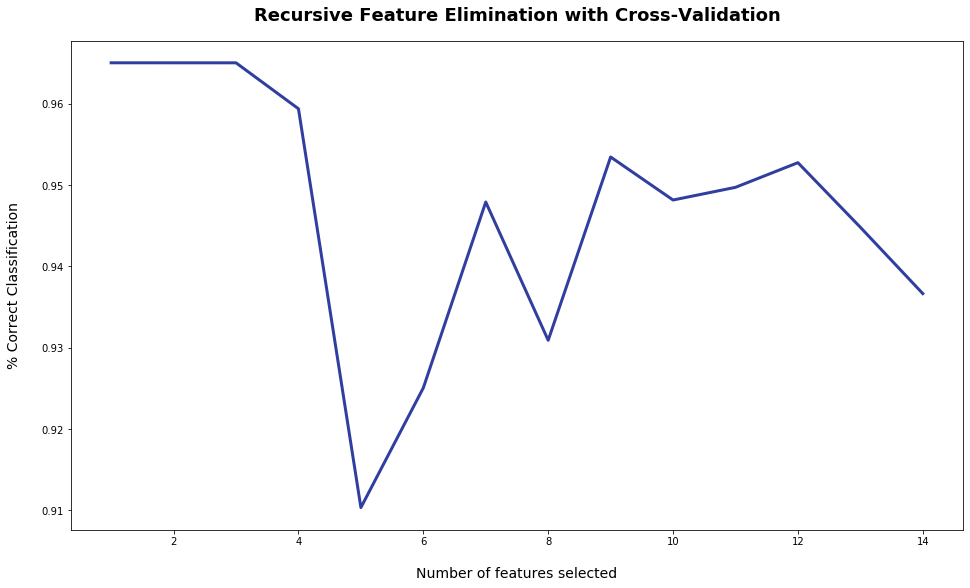

In [104]:
plt.figure(figsize=(16, 9))
plt.title(
    'Recursive Feature Elimination with Cross-Validation', 
    fontsize=18, fontweight='bold', pad=20
)

plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)

plt.plot(
    range(1, len(rfecv.grid_scores_) + 1), 
    rfecv.grid_scores_, color='#303F9F', linewidth=3
)

plt.show()

## show feature ranking

In [105]:
print(rfecv.ranking_)

[ 6 12 13  3 10  8  2  4  5  1 14 11  9  7]


- now top 1 is D11
- followed by D8 and D5

## do RFE with CV using Random Forest

In [107]:
%%time

no_fraud_column_dataframe = dataframe.drop('isFraud', axis=1)
is_fraud_data = dataframe['isFraud']

rf_classifier = RandomForestClassifier(n_jobs=2, verbose=1)
rfecv = RFECV(rf_classifier, scoring='accuracy', n_jobs=2, verbose=1)

rfecv.fit(no_fraud_column_dataframe, is_fraud_data)

Fitting estimator with 14 features.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   40.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   40.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.5s


CPU times: user 4min 1s, sys: 324 ms, total: 4min 1s
Wall time: 25min 29s


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   40.2s finished


RFECV(cv=None,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=2,
                                       oob_score=False, random_state=None,
                                       verbose=1, warm_start=False),
      min_features_to_select=1, n_jobs=2, scoring='accuracy', step=1,
      verbose=1)

In [108]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 13


## show feature ranking

In [110]:
print(rfecv.ranking_)

[1 1 1 1 2 1 1 1 1 1 1 1 1 1]


## plot of accuracy vs number of features

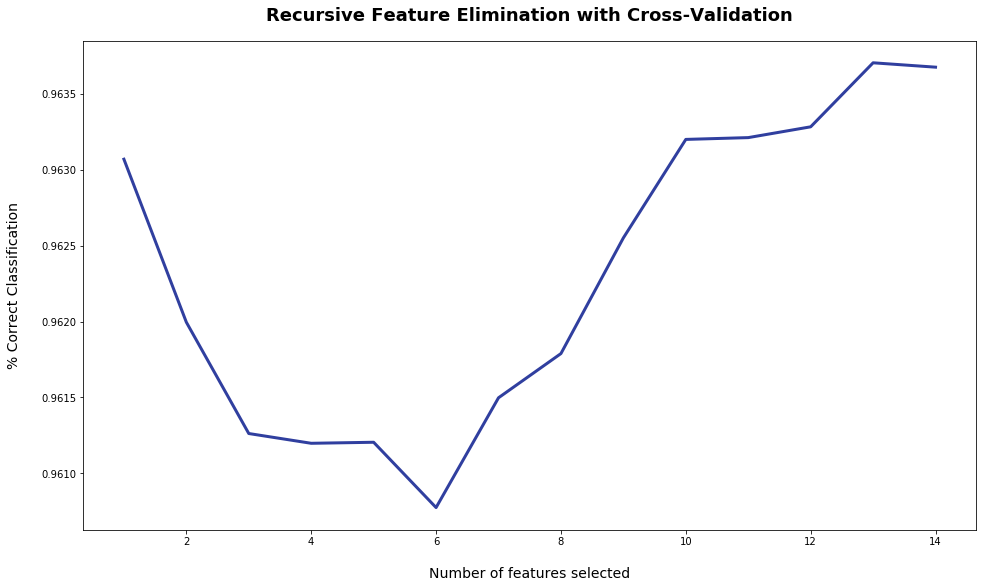

In [112]:
plt.figure(figsize=(16, 9))
plt.title(
    'Recursive Feature Elimination with Cross-Validation', 
    fontsize=18, fontweight='bold', pad=20
)

plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)

plt.plot(
    range(1, len(rfecv.grid_scores_) + 1), 
    rfecv.grid_scores_, color='#303F9F', linewidth=3
)

plt.show()

## plot feature importance

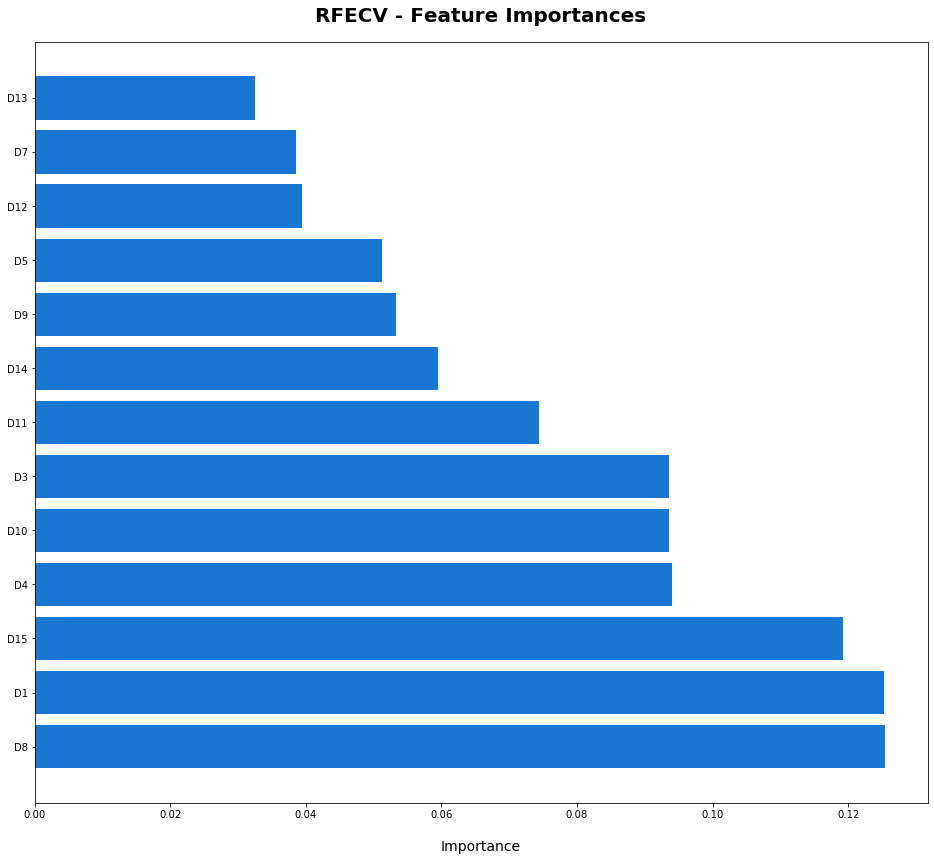

In [111]:
feature_importance_dataframe = pd.DataFrame()

temp = no_fraud_column_dataframe.drop('D6', axis=1)
feature_importance_dataframe['attr'] = temp.columns

feature_importance_dataframe['importance'] = rfecv.estimator_.feature_importances_

feature_importance_dataframe = feature_importance_dataframe.sort_values(
    by='importance', ascending=False
)


plt.figure(figsize=(16, 14))
plt.barh(
    y=feature_importance_dataframe['attr'], 
    width=feature_importance_dataframe['importance'], 
    color='#1976D2'
)

plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)

plt.show()

- now its D8, D1 and D15

## result

- seems inconclusive
- not sure which D-features to keep
- best bet is to exclude columns with high percentage of NaNs
- apparently, [decision trees can deal with multicollinearity](https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4), so no need to worry about D2 being highly correlated to D1

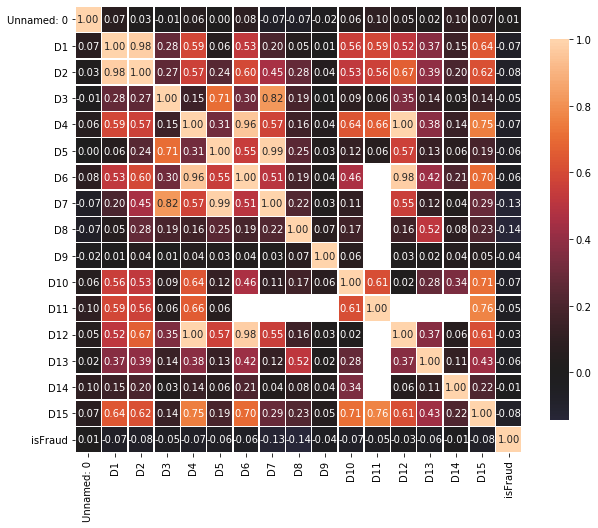

In [5]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(pd.read_csv('data/all_D_features.csv'))